# **Classify Images based on *master category* label from *styles* dataframe**

# **Load Libraries**

In [1]:
pip install keras

In [2]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 590.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 71.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 109.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 100.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 109.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.1 MB/s eta 0:00:00


In [3]:
pip install pillow # https://pypi.org/project/pillow/

In [4]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 19.1 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import cv2  # OpenCV
from PIL import Image  # Pillow
from skimage.feature import hog, local_binary_pattern
import random
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

# **EDA on Styles Data**

In [6]:
# Load labels of the images from styles.csv into a dataframe
df = pd.read_csv('data/styles.csv')

In [7]:
# 'id' in this dataframe represents the name of the image file (ex.49543.jpg; The 49543 is the id of the image in the dataframe)
df.sample(5)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
31942,9988,Men,Apparel,Topwear,Tshirts,Blue,Fall,2011.0,Sports,Nike Men As Rafa Ace T Blue T-Shirts
5900,18583,Women,Accessories,Socks,Socks,Pink,Fall,2011.0,Casual,Puma Women Sneakers Pink Striped Socks
6122,5726,Men,Footwear,Shoes,Sports Shoes,Black,Summer,2011.0,Sports,Reebok Men's Zigfuel Black Yellow Shoe
31794,14547,Women,Apparel,Topwear,Kurtas,Maroon,Fall,2011.0,Ethnic,Vishudh Women Floral Print Maroon Kurtas
22389,32353,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Q&Q Women Silver Dial Watch


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44446 entries, 0 to 44445
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44446 non-null  int64  
 1   gender              44446 non-null  object 
 2   masterCategory      44446 non-null  object 
 3   subCategory         44446 non-null  object 
 4   articleType         44446 non-null  object 
 5   baseColour          44431 non-null  object 
 6   season              44425 non-null  object 
 7   year                44445 non-null  float64
 8   usage               44129 non-null  object 
 9   productDisplayName  44439 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 3.4+ MB


In [9]:
# Missing values in Dataframe by percentage
df_missing = df.isnull().sum()/df.shape[0]*100
df_missing = df_missing.sort_values(ascending=False)
df_missing
#df_missing.plot.hist()

,0
usage,0.713225
season,0.047248
baseColour,0.033749
productDisplayName,0.015749
year,0.002250
id,0.000000
gender,0.000000
articleType,0.000000
masterCategory,0.000000
subCategory,0.000000


In [10]:
#Remove missing values even though the missing values percentage is very low and does not affect the classification
df = df.dropna(axis=0)

In [11]:
df.shape

(44099, 10)

In [13]:
# DataFrame of Master Category Data Distribution
df_master_category = df.groupby(['masterCategory'])['masterCategory'].count().reset_index(name='count')
df_master_category

,masterCategory,count
0,Accessories,11259
1,Apparel,21369
2,Footwear,9200
3,Free Items,105
4,Home,1
5,Personal Care,2140
6,Sporting Goods,25


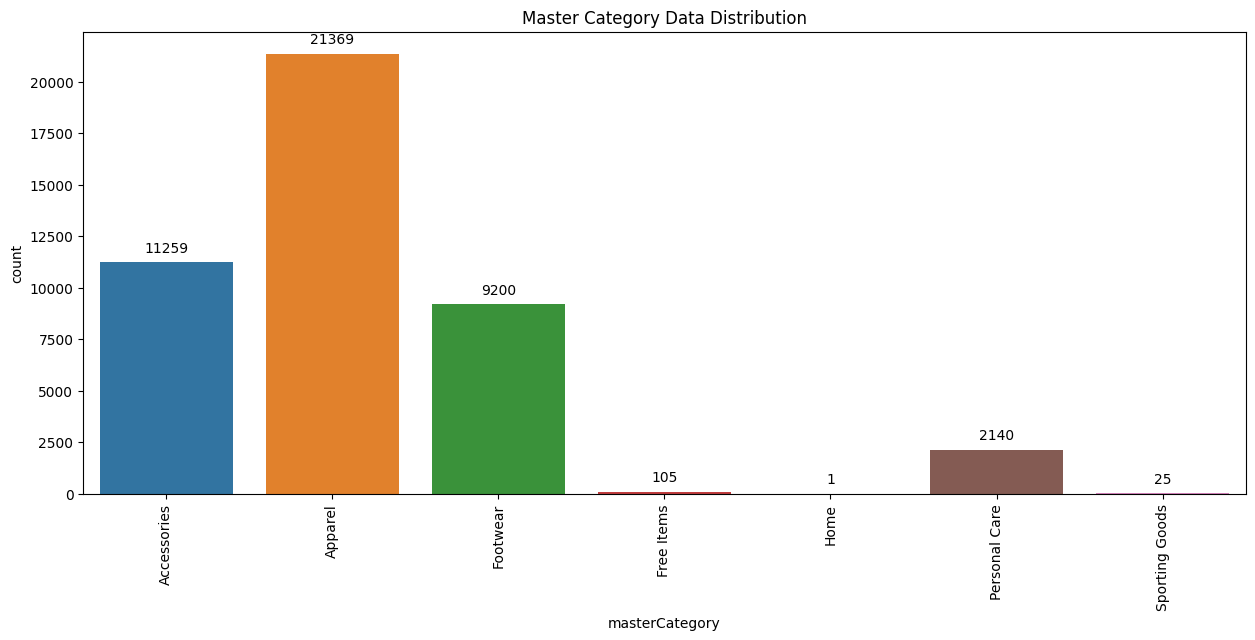

In [14]:
# Graphical representation of Master Category Data Distribution
plt.figure(figsize=(15,6))
barplot = sns.barplot(x='masterCategory', y='count', hue= 'masterCategory', data=df_master_category)
plt.title('Master Category Data Distribution')
plt.xticks(rotation=90)

# Add count annotations
for bar in barplot.patches:
    height = bar.get_height()
    barplot.annotate(f'{int(height)}',  # Display as an integer
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 5),  # Offset position slightly above the bar
                     textcoords="offset points",
                     ha='center', va='bottom')  # Centered horizontally

plt.show()

In [15]:
# DataFrame of Sub Category Data Distribution
df_sub_category = df.groupby(['subCategory'])['subCategory'].count().reset_index(name='count')
df_sub_category

,subCategory,count
0,Accessories,143
1,Apparel Set,106
2,Bags,3053
3,Bath and Body,9
4,Beauty Accessories,3
5,Belts,811
6,Bottomwear,2686
7,Cufflinks,108
8,Dress,478
9,Eyes,34


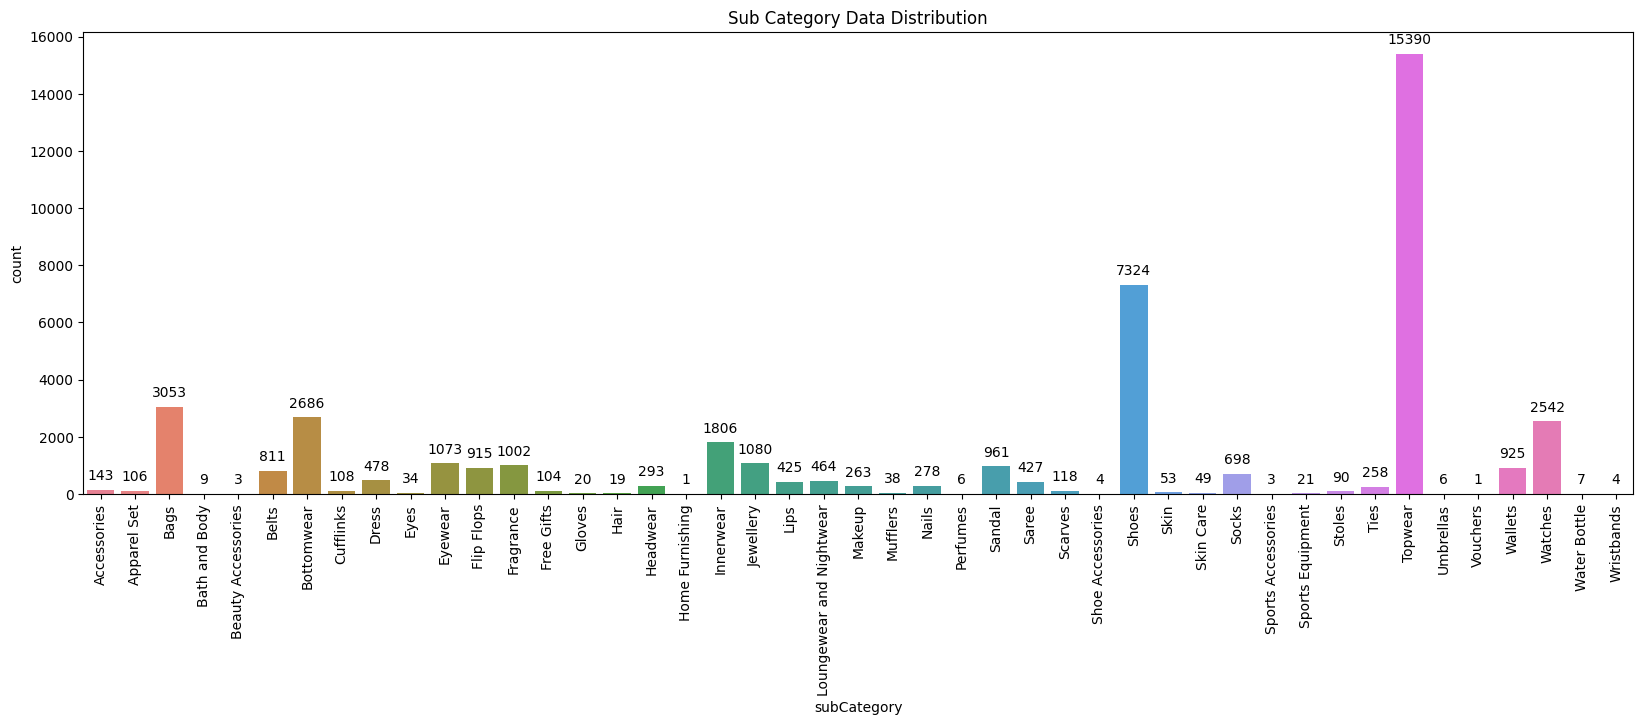

In [16]:
# Graphical representation of Sub Category Data Distribution
plt.figure(figsize=(20,6))
barplot = sns.barplot(x='subCategory', y='count', hue='subCategory', data=df_sub_category)
plt.title('Sub Category Data Distribution')
plt.xticks(rotation=90)

# Add count annotations
for bar in barplot.patches:
    height = bar.get_height()
    barplot.annotate(f'{int(height)}',  # Display as an integer
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 5),  # Offset position slightly above the bar
                     textcoords="offset points",
                     ha='center', va='bottom')  # Centered horizontally

plt.show()

In [17]:
# DataFrame of Article Type Data Distribution
df_articleType = df.groupby(['articleType'])['articleType'].count().reset_index(name='count')
df_articleType

,articleType,count
0,Accessory Gift Set,111
1,Baby Dolls,14
2,Backpacks,724
3,Bangle,85
4,Basketballs,13
...,...,...
137,Waistcoat,15
138,Wallets,928
139,Watches,2542
140,Water Bottle,11


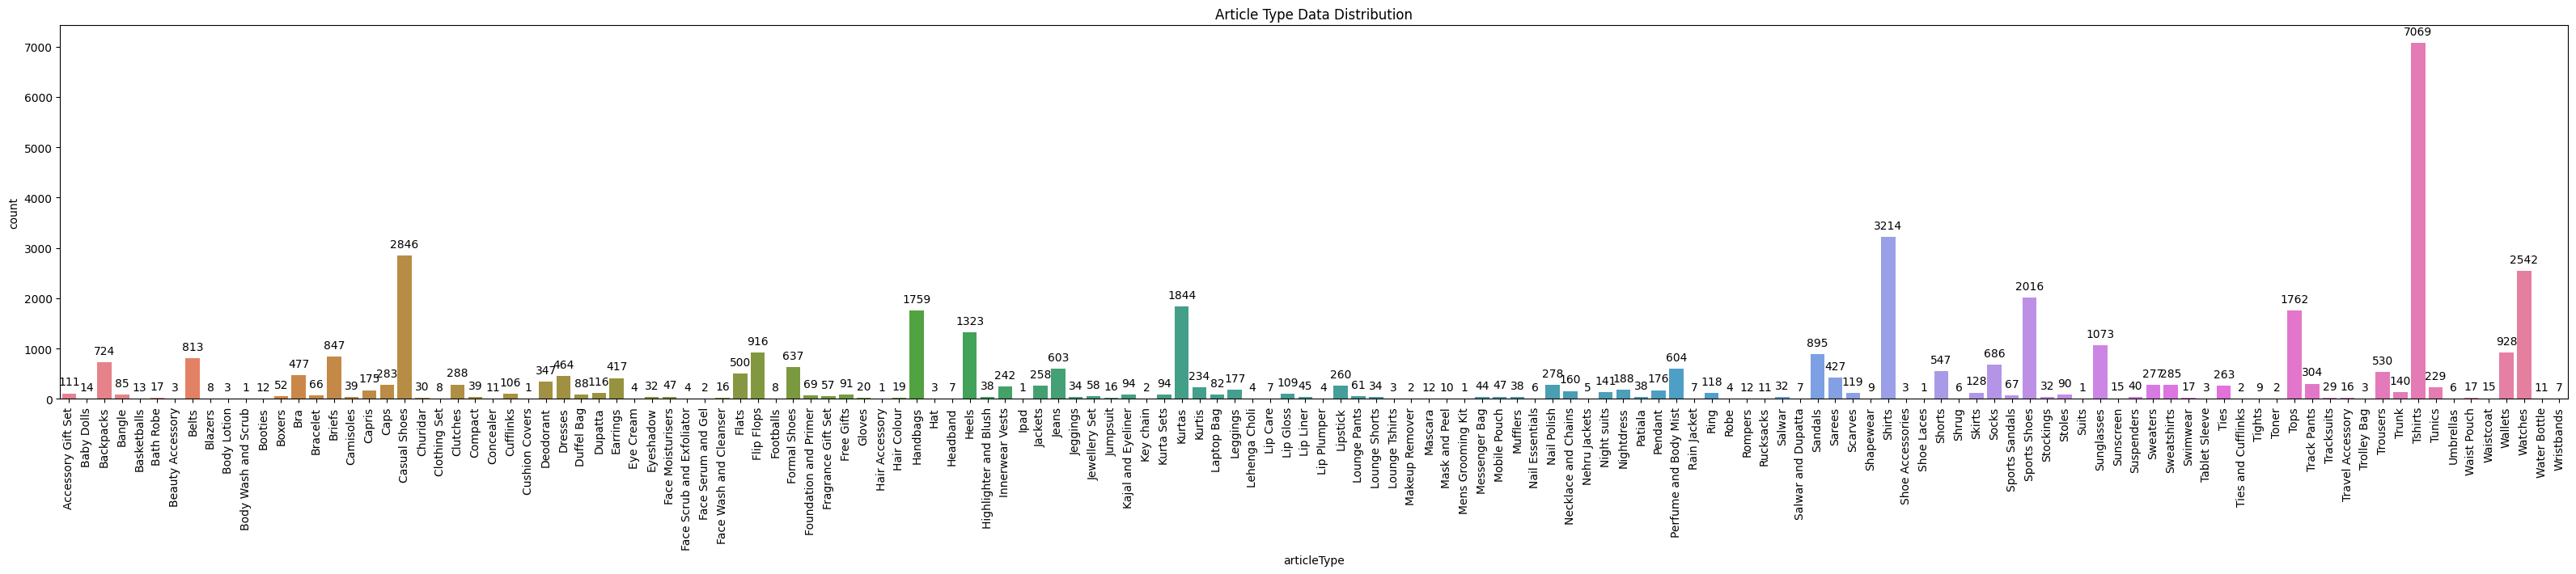

In [18]:
# Graphical representation of Article Type Data Distribution
plt.figure(figsize=(40,6))
barplot = sns.barplot(x='articleType', y='count', hue= 'articleType',data=df_articleType)
plt.title('Article Type Data Distribution')
plt.xticks(rotation=90)

# Add count annotations
for bar in barplot.patches:
    height = bar.get_height()
    barplot.annotate(f'{int(height)}',  # Display as an integer
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 5),  # Offset position slightly above the bar
                     textcoords="offset points",
                     ha='center', va='bottom')  # Centered horizontally

plt.show()

In [19]:
# Dataframe: colour Distribution by Gender
df_gender_colour = df.groupby(['gender','baseColour'])['gender'].count().reset_index(name='count')
df_gender_colour

,gender,baseColour,count
0,Boys,Beige,6
1,Boys,Black,83
2,Boys,Blue,159
3,Boys,Brown,10
4,Boys,Charcoal,1
...,...,...,...
157,Women,Taupe,11
158,Women,Teal,87
159,Women,Turquoise Blue,55
160,Women,White,1993


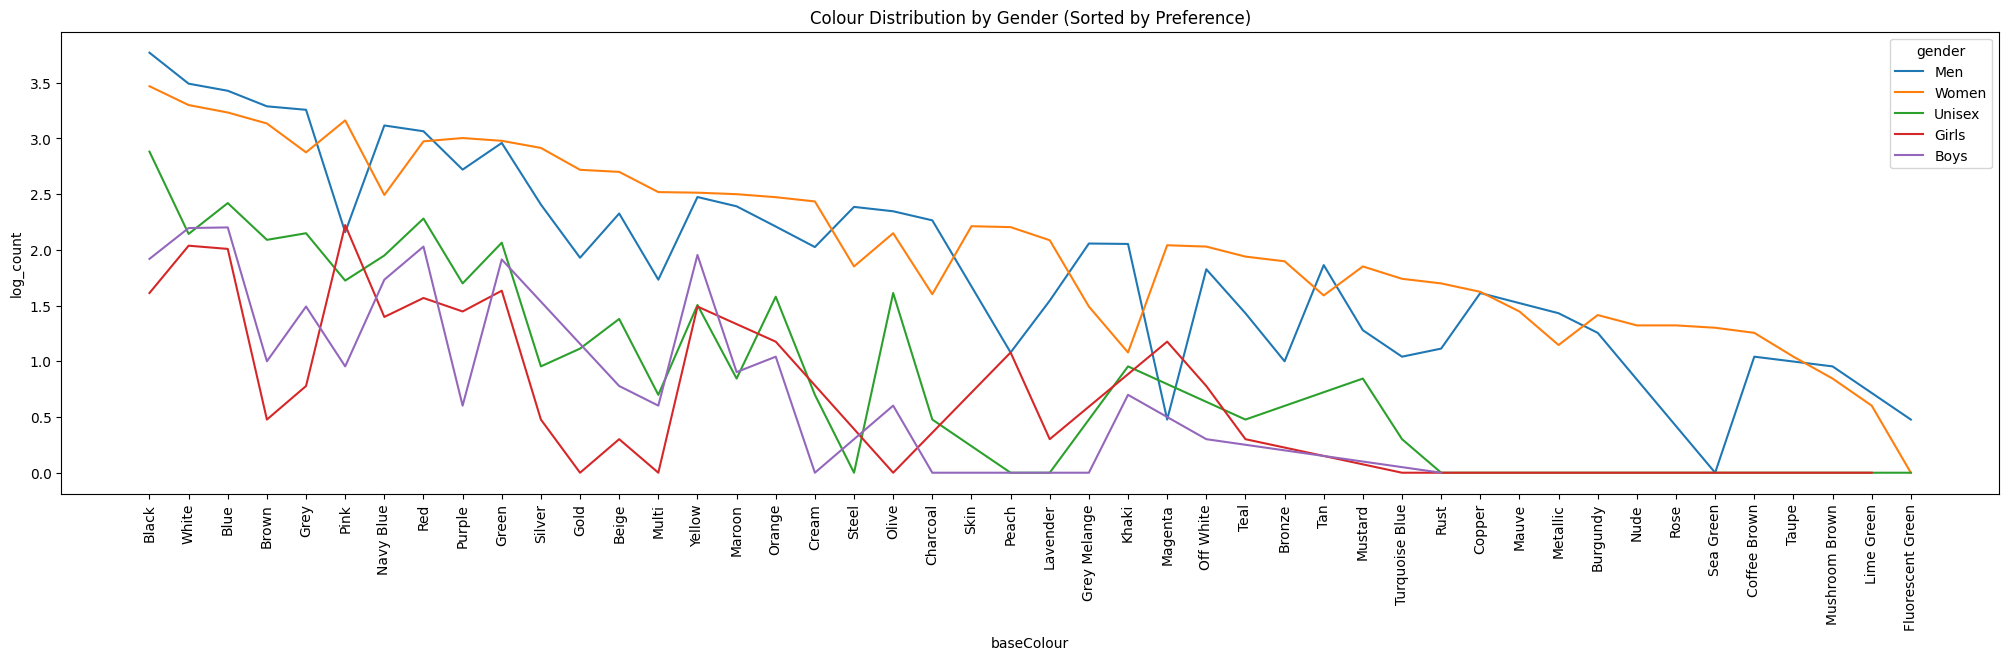

In [20]:
# Graphical representation of colour distribution by Gender
df_gender_colour_sorted = df_gender_colour.sort_values(by='count', ascending=False)

# Create the barplot
plt.figure(figsize=(25, 6))
df_gender_colour_sorted['log_count'] = np.log10(df_gender_colour_sorted['count'])
sns.lineplot(x='baseColour', y='log_count', hue='gender', data=df_gender_colour_sorted)
plt.title('Colour Distribution by Gender (Sorted by Preference)')
plt.xticks(rotation=90)
plt.show()

In [21]:
# Images colour distribution by Master Category
df_master_category = df.groupby(['masterCategory','baseColour'])['masterCategory'].count().reset_index(name='count')
df_master_category

,masterCategory,baseColour,count
0,Accessories,Beige,202
1,Accessories,Black,3296
2,Accessories,Blue,712
3,Accessories,Bronze,29
4,Accessories,Brown,1306
...,...,...,...
192,Sporting Goods,Grey,1
193,Sporting Goods,Orange,2
194,Sporting Goods,Red,3
195,Sporting Goods,White,6


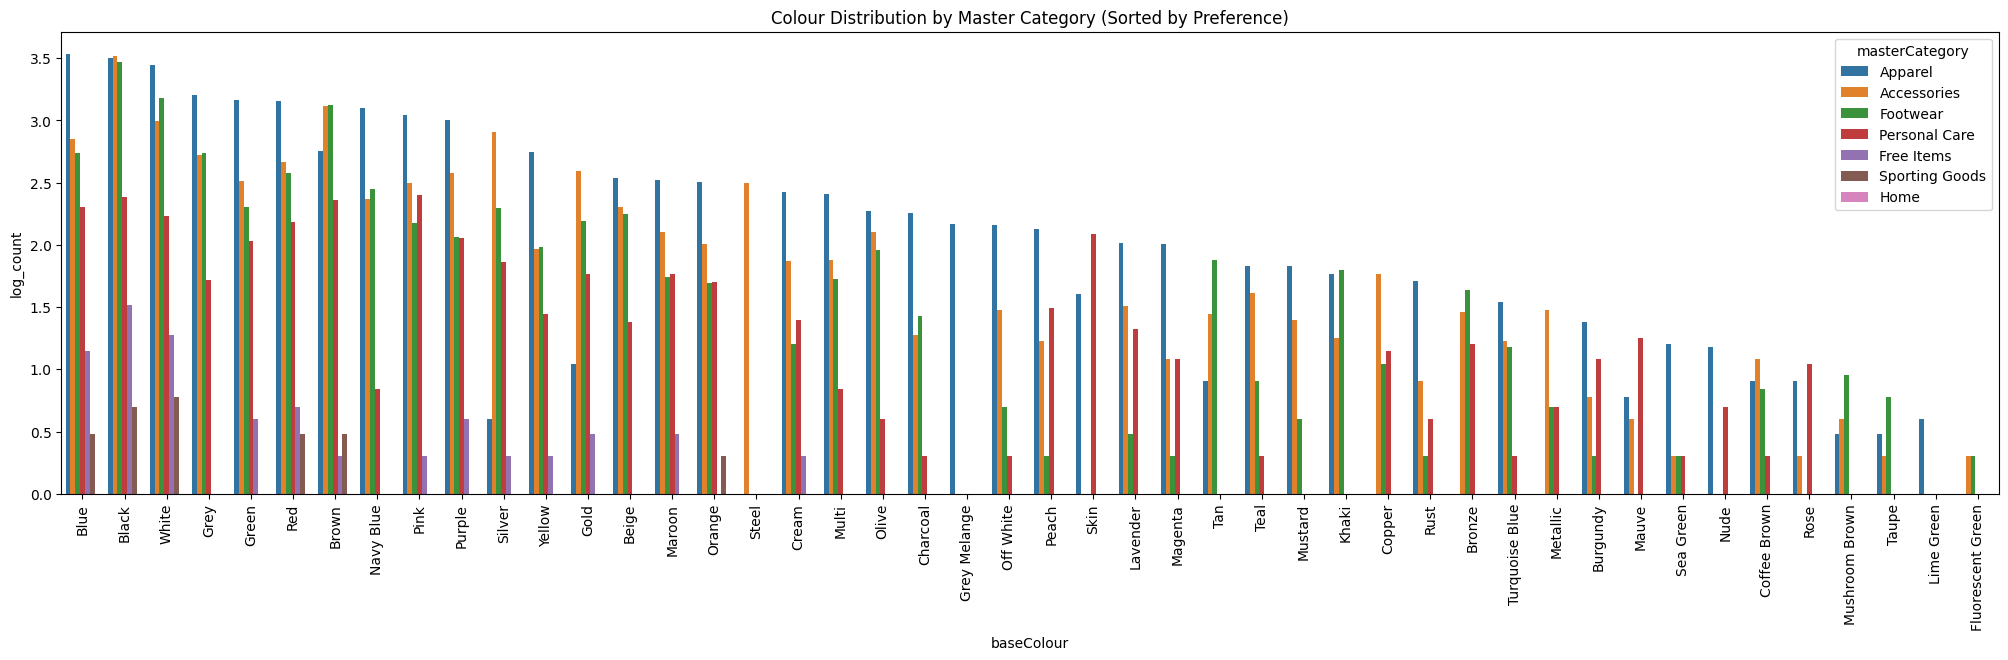

In [22]:
# Images colour distribution by Master Category
df_master_category_sorted = df_master_category.sort_values(by='count', ascending=False)

# Create the barplot
plt.figure(figsize=(25, 6))
df_master_category_sorted['log_count'] = np.log10(df_master_category_sorted['count'])
sns.barplot(x='baseColour', y='log_count', hue='masterCategory', data=df_master_category_sorted)
plt.title('Colour Distribution by Master Category (Sorted by Preference)')
plt.xticks(rotation=90)
plt.show()

In [23]:
# Images colour distribution by usage
df_usage = df.groupby(['usage','baseColour'])['usage'].count().reset_index(name='count')
df_usage

,usage,baseColour,count
0,Casual,Beige,581
1,Casual,Black,7474
2,Casual,Blue,3868
3,Casual,Bronze,88
4,Casual,Brown,2873
...,...,...,...
176,Travel,Brown,2
177,Travel,Green,6
178,Travel,Grey,2
179,Travel,Pink,1


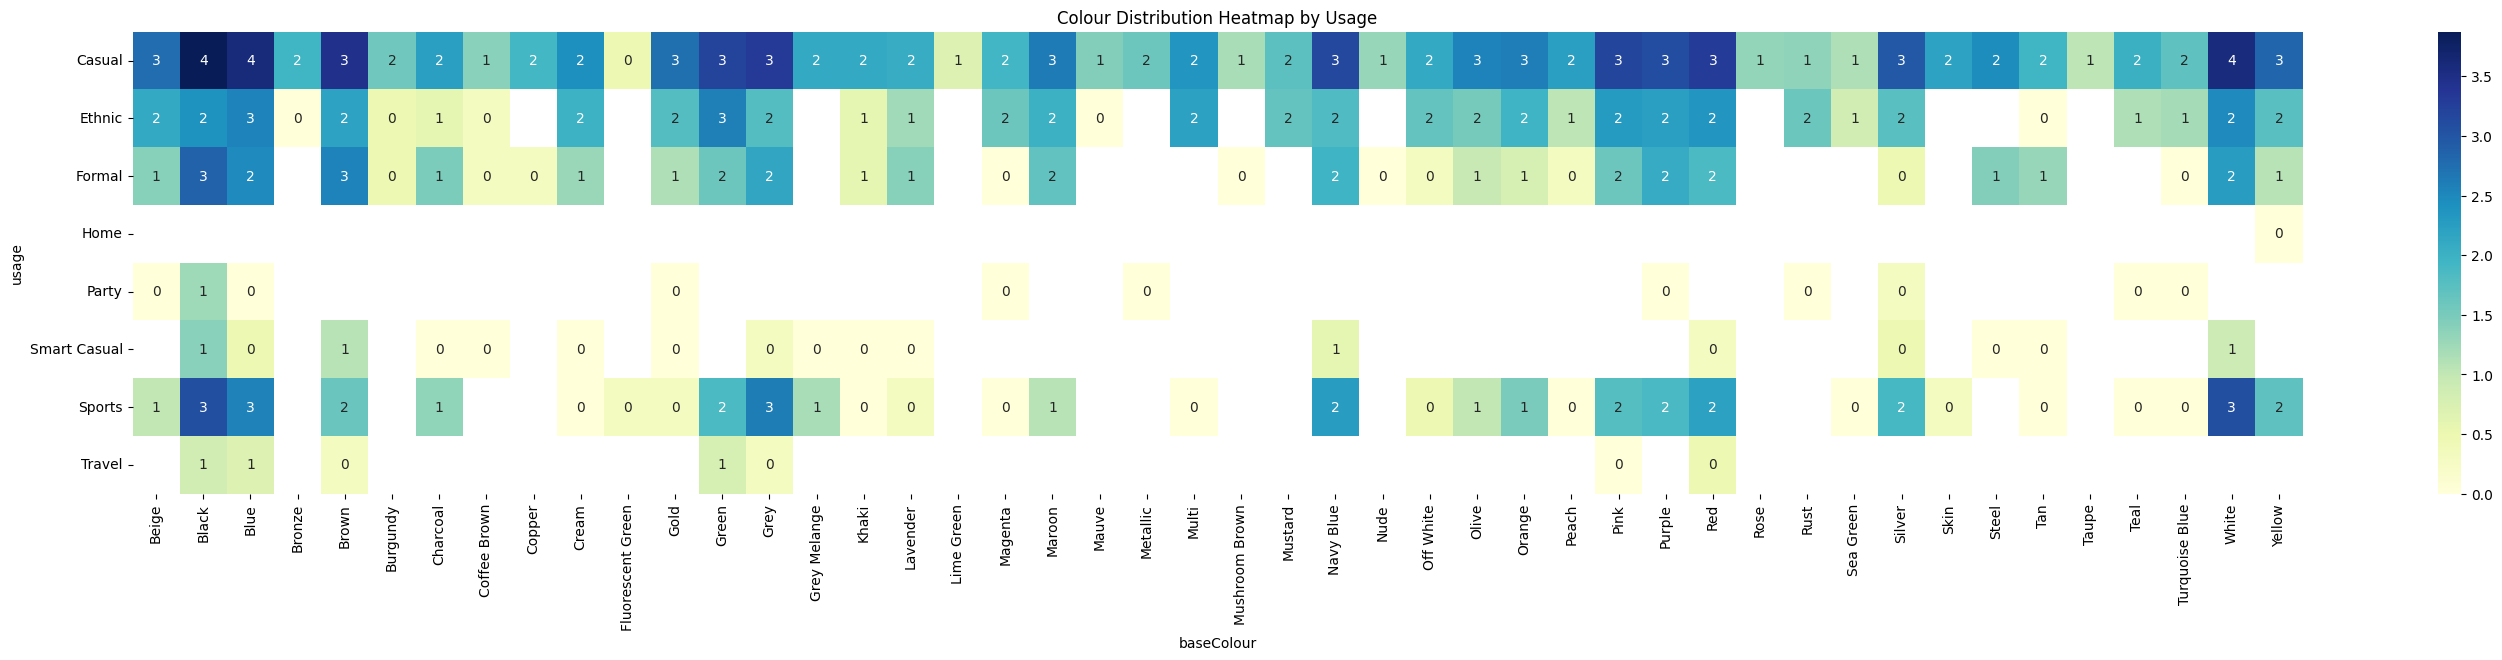

In [24]:
# Graphical representation of colour distribution by usage

# Create the heatmap
plt.figure(figsize=(35, 6))
df_usage['log_count'] = np.log10(df_usage['count'])
# Pass arguments as keywords to pivot
pivot_table = df_usage.pivot(index='usage', columns='baseColour', values='log_count')
sns.heatmap(pivot_table, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title('Colour Distribution Heatmap by Usage')
plt.xticks(rotation=90)
plt.show()

# **EDA on Images Data**

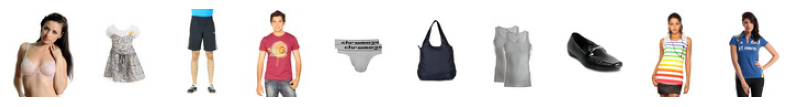

In [33]:
# Display sample pictures
import matplotlib.pyplot as plt
import os
from keras.preprocessing.image import load_img, img_to_array

# Function to display sample images
def display_sample_images(image_folder, num_samples=5):
    plt.figure(figsize=(10, 5))
    for i, filename in enumerate(os.listdir(image_folder)[:num_samples]):
        img_path = os.path.join(image_folder, filename)
        img = load_img(img_path)
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

# Display sample images
display_sample_images('images', num_samples=10)


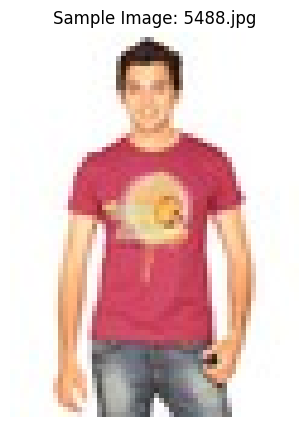

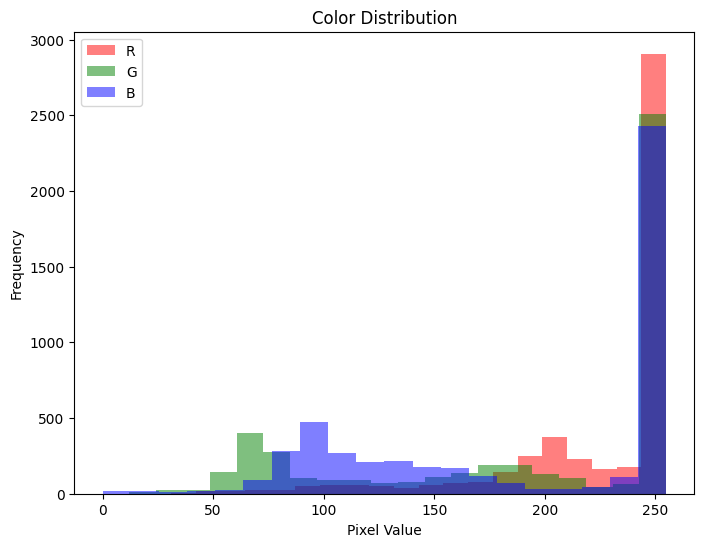

In [34]:
# Plot colour distribution of a sample image
def plot_color_distribution(image_folder, sample_image_filename):
    img_path = os.path.join(image_folder, sample_image_filename)
    img = img_to_array(load_img(img_path))

    # Display the image
    plt.figure(figsize=(5, 5))
    plt.imshow(img/255.) # Display the image (normalized for display)
    plt.axis('off')
    plt.title(f"Sample Image: {sample_image_filename}")
    plt.show()

    # Plot color distribution
    colors = ('r', 'g', 'b')
    plt.figure(figsize=(8, 6))
    for i, color in enumerate(colors):
        plt.hist(img[:, :, i].ravel(), bins=20, color=color, alpha=0.5, label=color.upper())
    plt.title('Color Distribution')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Plot color distribution for a sample image
image_files = os.listdir('images')
sample_image_filename = image_files[3]  # Take the first image as a sample
plot_color_distribution('images', sample_image_filename)  # Pass the filename to the function

# **Pre-processing of data: Images and Labels**

In [35]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import image_dataset_from_directory
# Load images from the images folder
def load_images_from_folder(folder, img_size=(224, 224), df=None):  # Pass the DataFrame to the function
    images = []
    labels = []

    for subdir, dirs, files in os.walk(folder):
        for file in files:
            try:
                # Extract image ID from filename (assuming filename format: id_*.jpg)
                image_id = int(file.split('.')[0])

                # Get the corresponding 'masterCategory' from the DataFrame
                label_series = df.loc[df['id'] == image_id, 'masterCategory']
                if not label_series.empty:  # Check if the series is not empty
                    label = label_series.values[0]
                else:
                    print(f"Warning: No label found for image ID {image_id} in file {file}. Skipping this image.")
                    continue  # Skip this image and go to the next one

                img_path = os.path.join(subdir, file)
                img = load_img(img_path, target_size=img_size)
                img_array = img_to_array(img)
                images.append(img_array)
                labels.append(label)
            except ValueError:
                 print(f"Warning: Unable to process file {file}. Is the file in the correct format? Skipping this image.")
                 continue
            except Exception as e:
                print(f"Warning: Error loading or processing {file}. Error: {e}. Skipping this image.")
                continue
    return np.array(images), np.array(labels)

# Load the dataframe (make sure this matches where the actual file is located)
df = pd.read_csv('data/styles.csv')

# Load images, passing the DataFrame to get labels
folder = "images"
X, y = load_images_from_folder(folder, df=df)  # Pass the DataFrame here

# Perform train-test split using the new 'y'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# Normalize image data
X_train = X_train / 255.0
X_test = X_test / 255.0

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (2669, 224, 224, 3)
Testing data shape: (668, 224, 224, 3)


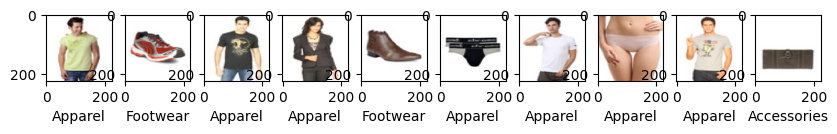

In [36]:
# 4. Sampling few images
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.xticks()
    plt.yticks()
    plt.grid(False)
#    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.imshow(X_train[i], cmap=plt.cm.magma)
    plt.xlabel(y_train[i])
plt.show()

# **Modeling**

In [37]:
# Evaluate_model function:
def evaluate_model(model, X_test, y_test, model_name):
   y_pred = model.predict(X_test)
   accuracy = accuracy_score(y_test, y_pred)
   print(f"{model_name} Accuracy: {accuracy}")
   print(classification_report(y_test, y_pred))

    # Confusion Matrix Visualization (Seaborn)
   cm = confusion_matrix(y_test, y_pred)

    # Get unique class names from y_test and y_pred
   class_names_unique = np.unique(np.concatenate((y_test, y_pred)))

   cm_df = pd.DataFrame(cm, index=class_names_unique, columns=class_names_unique)  # Use unique class names
   print(f"{model_name} Confusion Matrix:")
   print(cm_df)

In [39]:
def evaluate_model1(model, X_test, y_test, model_name):
    # Predict probabilities and get predicted class labels
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)  # Get the class with highest probability

    # If using label encoding, inverse transform to original labels
    if isinstance(model, keras.Sequential):  # Assuming CNN model is a keras.Sequential
        # Get the label encoder
        label_encoder = globals().get('label_encoder')
        if label_encoder:
            y_pred = label_encoder.inverse_transform(y_pred)  # Convert back to original labels

    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy}")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix Visualization (Seaborn)
    cm = confusion_matrix(y_test, y_pred)

    # Get unique class names from y_test and y_pred
    class_names_unique = np.unique(np.concatenate((y_test, y_pred)))

    cm_df = pd.DataFrame(cm, index=class_names_unique, columns=class_names_unique)  # Use unique class names
    print(f"{model_name} Confusion Matrix:")
    print(cm_df)

In [40]:
# Model1: SVM model
 # SVM with Raw Images (Reshaped)
# Reshape images for SVM (flatten)
x_train_reshaped = X_train.reshape(X_train.shape[0], -1)
x_test_reshaped = X_test.reshape(X_test.shape[0], -1)

svm_images = SVC(kernel='rbf', C=1.0, gamma='scale')
svm_images.fit(x_train_reshaped, y_train)

SVC()

In [41]:
# Evaluate model1 (SVM performance)

evaluate_model(svm_images, x_test_reshaped, y_test, "SVM with Raw Images")

SVM with Raw Images Accuracy: 0.9520958083832335
               precision    recall  f1-score   support

  Accessories       0.85      0.95      0.90       110
      Apparel       0.97      0.96      0.96       346
     Footwear       0.99      0.99      0.99       146
   Free Items       0.00      0.00      0.00         2
Personal Care       0.96      0.86      0.91        64

     accuracy                           0.95       668
    macro avg       0.76      0.75      0.75       668
 weighted avg       0.95      0.95      0.95       668

SVM with Raw Images Confusion Matrix:
               Accessories  Apparel  Footwear  Free Items  Personal Care
Accessories            104        5         1           0              0
Apparel                 13      332         0           0              1
Footwear                 0        0       145           0              1
Free Items               1        1         0           0              0
Personal Care            4        5         0     

In [46]:
# Get predictions from the trained model
y_pred = svm_images.predict(x_test_reshaped)

<Figure size 2000x2000 with 0 Axes>

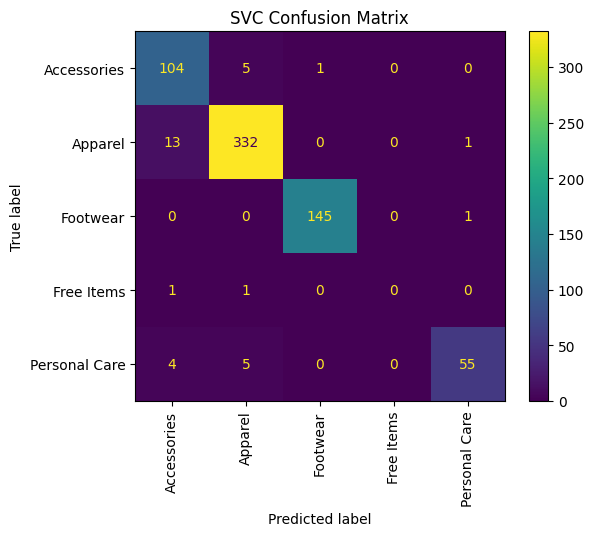

In [50]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder
# Assuming y_train contains your original training labels
label_encoder = LabelEncoder()  # Create a LabelEncoder instance
label_encoder.fit(y_train)  # Fit the encoder to your training labels

confusionMatrix = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix, display_labels=label_encoder.classes_)
plt.figure(figsize=(20, 20))
cmd.plot()
plt.title("SVC Confusion Matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [51]:
# Model2: KNN Model
# KNN classifier
# Train a KNN model
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(x_train_reshaped, y_train)

KNeighborsClassifier(n_neighbors=3)

In [52]:
# Evalauate model2 (KNN performance)
evaluate_model(knn_model, x_test_reshaped, y_test, "KNN model evaluation")

KNN model evaluation Accuracy: 0.9505988023952096
               precision    recall  f1-score   support

  Accessories       0.94      0.84      0.88       110
      Apparel       0.95      0.98      0.96       346
     Footwear       0.99      0.99      0.99       146
   Free Items       1.00      0.50      0.67         2
Personal Care       0.89      0.92      0.91        64

     accuracy                           0.95       668
    macro avg       0.95      0.85      0.88       668
 weighted avg       0.95      0.95      0.95       668

KNN model evaluation Confusion Matrix:
               Accessories  Apparel  Footwear  Free Items  Personal Care
Accessories             92       12         1           0              5
Apparel                  5      338         1           0              2
Footwear                 0        1       145           0              0
Free Items               0        1         0           1              0
Personal Care            1        4         0   

In [53]:
# Get predictions from the trained model
y_pred = knn_model.predict(x_test_reshaped)

<Figure size 2000x2000 with 0 Axes>

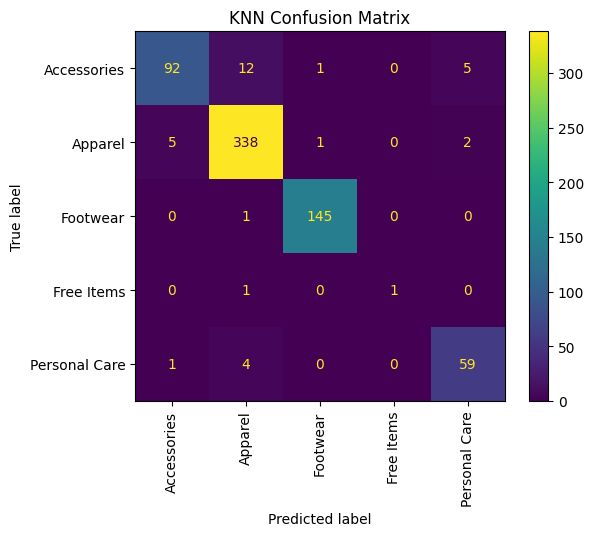

In [54]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder
# Assuming y_train contains your original training labels
label_encoder = LabelEncoder()  # Create a LabelEncoder instance
label_encoder.fit(y_train)  # Fit the encoder to your training labels

confusionMatrix = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix, display_labels=label_encoder.classes_)
plt.figure(figsize=(20, 20))
cmd.plot()
plt.title("KNN Confusion Matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

In [55]:
# Model3: RandomForest model
# RandomForest classifier
# Train a RandomForest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train_reshaped, y_train)

RandomForestClassifier(random_state=42)

In [56]:
# Evalauate model3 (RandomForest performance)
# Evalauate RandomForest model
evaluate_model(rf_model, x_test_reshaped, y_test, "RandomForest model evaluation")

RandomForest model evaluation Accuracy: 0.9640718562874252
               precision    recall  f1-score   support

  Accessories       0.89      0.93      0.91       110
      Apparel       0.98      0.97      0.97       346
     Footwear       0.99      0.99      0.99       146
   Free Items       1.00      0.50      0.67         2
Personal Care       0.95      0.94      0.94        64

     accuracy                           0.96       668
    macro avg       0.96      0.87      0.90       668
 weighted avg       0.96      0.96      0.96       668

RandomForest model evaluation Confusion Matrix:
               Accessories  Apparel  Footwear  Free Items  Personal Care
Accessories            102        7         1           0              0
Apparel                  7      336         0           0              3
Footwear                 1        0       145           0              0
Free Items               1        0         0           1              0
Personal Care            3    

In [57]:
# Get predictions from the trained model
y_pred = rf_model.predict(x_test_reshaped)

<Figure size 2000x2000 with 0 Axes>

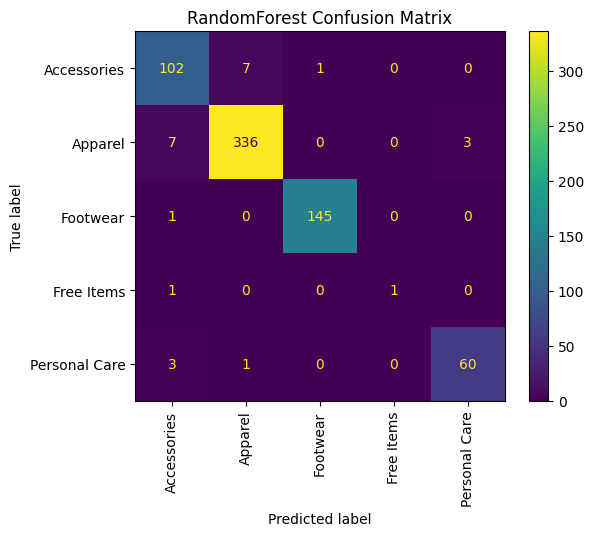

In [58]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder
# Assuming y_train contains your original training labels
label_encoder = LabelEncoder()  # Create a LabelEncoder instance
label_encoder.fit(y_train)  # Fit the encoder to your training labels

confusionMatrix = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix, display_labels=label_encoder.classes_)
plt.figure(figsize=(20, 20))
cmd.plot()
plt.title("RandomForest Confusion Matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# **HyperParameter Tuning and GridSearachCV**

**The step execution takes long time atleast 20 minutes for 500+ images, so plan accordingly to run.**

In [ ]:
# Only SVC, KNN, RandormForest are being selected. GradientBoosting was excluded as it is taking lot longer time to train the images.
# Define the parameter grid for each model
param_grid = {
    'SVC': {
        'kernel': ['linear', 'rbf', 'poly'],
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto']
    },
    'KNN': {
        'n_neighbors': [3, 5, 7],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'RandomForest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
}

# Create a dictionary to store the models
models = {
    'SVC': SVC(),
    'KNN': KNeighborsClassifier(),
    'RandomForest': RandomForestClassifier()
}

# Create a dictionary to store the best models and parameters
best_models = {}

# Perform GridSearchCV for each model
for model_name, model in models.items():
    grid_search = GridSearchCV(model, param_grid[model_name], cv=5, scoring='accuracy')
    grid_search.fit(x_train_reshaped, y_train)  # Use your training data here

    best_models[model_name] = {
        'model': grid_search.best_estimator_,
        'params': grid_search.best_params_,
        'score': grid_search.best_score_
    }

# Print the best model and parameters for each algorithm
for model_name, results in best_models.items():
    print(f"Best {model_name}:")
    print(f"  Parameters: {results['params']}")
    print(f"  Score: {results['score']}")


# Evaluate the best models on the test set
for model_name, results in best_models.items():
  evaluate_model(results['model'], x_test_reshaped, y_test, f"Best {model_name}")


# **OpenCV** - Model performance evaluation using OpenCV, HOG, LBP via features extraction and SVC

In [59]:
# 6. Feature Extraction (Pillow/OpenCV, with Texture)
def extract_features(images):
     # Initialize an empty list to store features
    features = []
    for image in images:

        # Color Histogram (using OpenCV)
        if len(image.shape) == 3:  # If the image has 3 channels (RGB/BGR)
            image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        image = image.astype(np.uint8)
        hist = cv2.calcHist([image], [0], None, [256], [0, 256])  # Correct syntax for calcHist
        hist = hist.flatten()

        # HOG (Histogram of Oriented Gradients) - Texture
        hog_features, hog_image = hog(image, orientations=8, pixels_per_cell=(4, 4),
                                      cells_per_block=(2, 2), visualize=True)

        # LBP (Local Binary Patterns) - Texture
        radius = 1
        n_points = 8 * radius
        lbp = local_binary_pattern(image, n_points, radius, method='uniform')
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 2), range=(0, n_points + 1))
        lbp_hist = lbp_hist.astype("float")
        lbp_hist /= (lbp_hist.sum() + 1e-7)

        # Combine all features into a single array
        image_features = np.concatenate([hist, hog_features, lbp_hist])
        features.append(image_features)

    return np.array(features)

In [60]:
# Add feature for the Xtrain and Xtest

x_train_features = extract_features(X_train)
x_test_features = extract_features(X_test)

In [61]:
# 7. Feature Scaling (NumPy):
scaler = StandardScaler()
x_train_features_scaled = scaler.fit_transform(x_train_features)  # Input and output are NumPy arrays
x_test_features_scaled = scaler.transform(x_test_features)

In [62]:
# OpenCV : SVM with Extracted Features
svm_features = SVC(kernel='linear', C=0.1, gamma='auto') # Updated parameters as per the GridSearchCV in previous steps
svm_features.fit(x_train_features_scaled, y_train)

SVC(C=0.1, gamma='auto', kernel='linear')

In [63]:
# Evaluate OpenCV with SVM model

evaluate_model(svm_features, x_test_features_scaled, y_test, "SVM with Features")

SVM with Features Accuracy: 0.9236526946107785
               precision    recall  f1-score   support

  Accessories       0.90      0.82      0.86       110
      Apparel       0.90      0.98      0.94       346
     Footwear       0.98      0.88      0.93       146
   Free Items       1.00      0.50      0.67         2
Personal Care       0.97      0.94      0.95        64

     accuracy                           0.92       668
    macro avg       0.95      0.82      0.87       668
 weighted avg       0.93      0.92      0.92       668

SVM with Features Confusion Matrix:
               Accessories  Apparel  Footwear  Free Items  Personal Care
Accessories             90       19         1           0              0
Apparel                  5      338         1           0              2
Footwear                 2       16       128           0              0
Free Items               1        0         0           1              0
Personal Care            2        2         0         

In [68]:
# Get predictions from the trained model
y_pred = svm_features.predict(x_test_features_scaled)

<Figure size 2000x2000 with 0 Axes>

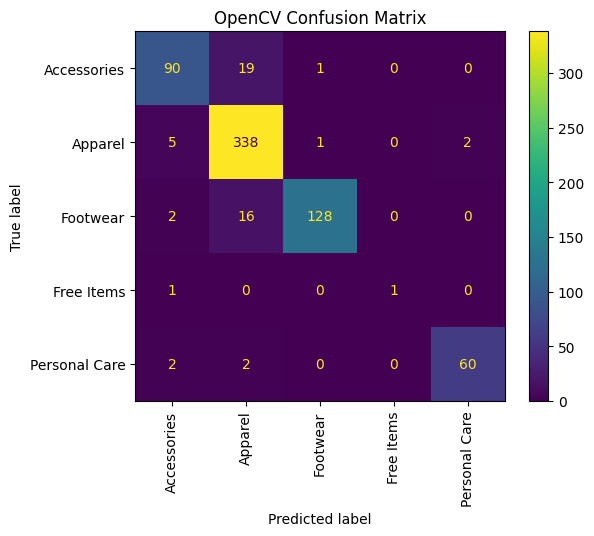

In [70]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import LabelEncoder # Import LabelEncoder
# Assuming y_train contains your original training labels
label_encoder = LabelEncoder()  # Create a LabelEncoder instance
label_encoder.fit(y_train)  # Fit the encoder to your training labels

confusionMatrix = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix, display_labels=label_encoder.classes_)
plt.figure(figsize=(20, 20))
cmd.plot()
plt.title("OpenCV Confusion Matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# **Pillow** - Model performance evaluation using Pillow and RandomForest

In [71]:
# Assuming you have a directory named 'images' with subdirectories for each class.

def load_images_from_folder(folder, img_size=(224, 224), df=None): # Pass the DataFrame to the function
    images = []
    labels = []
    for subdir, dirs, files in os.walk(folder):
        for file in files:
            # Extract image ID from filename (assuming filename format: id_*.jpg)
            image_id = int(file.split('.')[0])

            # Get the corresponding 'masterCategory' from the DataFrame
            label = df.loc[df['id'] == image_id, 'masterCategory'].values[0]
            image_path = os.path.join(subdir, file)

            try:
                img = Image.open(image_path).convert('RGB') # convert to RGB
                img = img.resize((64, 64)) # resize to a consistent size
                img_array = np.array(img).flatten() # flatten the image array
                images.append(img_array)
                labels.append(label)
            except Exception as e:
                 print(f"Error loading image {image_path}: {e}")
    return np.array(images), np.array(labels)

# Load images, passing the DataFrame to get labels
folder = "images"
X, y = load_images_from_folder(folder, df=df) # Pass the DataFrame here

# Perform train-test split using the new 'y'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an SVM classifier
#clf = SVC(kernel='linear') # you can change the kernel
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=None, min_samples_split=2, n_estimators=50, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.9715568862275449
               precision    recall  f1-score   support

  Accessories       0.93      0.89      0.91        99
      Apparel       0.98      0.99      0.98       365
     Footwear       0.99      0.99      0.99       140
   Free Items       0.00      0.00      0.00         3
Personal Care       0.98      0.98      0.98        61

     accuracy                           0.97       668
    macro avg       0.77      0.77      0.77       668
 weighted avg       0.97      0.97      0.97       668

[[ 88   8   2   0   1]
 [  3 362   0   0   0]
 [  1   0 139   0   0]
 [  3   0   0   0   0]
 [  0   1   0   0  60]]


In [72]:
# Evalauate Pillow model
evaluate_model(clf, X_test, y_test, "RandomForest with Pillow")

RandomForest with Pillow Accuracy: 0.9715568862275449
               precision    recall  f1-score   support

  Accessories       0.93      0.89      0.91        99
      Apparel       0.98      0.99      0.98       365
     Footwear       0.99      0.99      0.99       140
   Free Items       0.00      0.00      0.00         3
Personal Care       0.98      0.98      0.98        61

     accuracy                           0.97       668
    macro avg       0.77      0.77      0.77       668
 weighted avg       0.97      0.97      0.97       668

RandomForest with Pillow Confusion Matrix:
               Accessories  Apparel  Footwear  Free Items  Personal Care
Accessories             88        8         2           0              1
Apparel                  3      362         0           0              0
Footwear                 1        0       139           0              0
Free Items               3        0         0           0              0
Personal Care            0        1     

<Figure size 2000x2000 with 0 Axes>

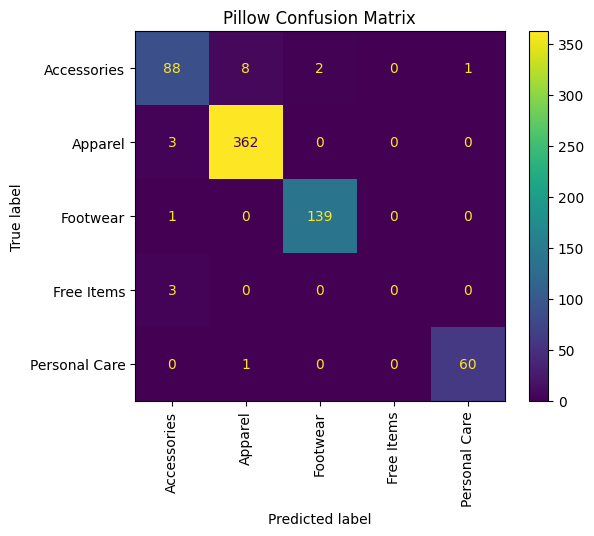

In [73]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
confusionMatrix = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix, display_labels=label_encoder.classes_)
plt.figure(figsize=(20, 20))
cmd.plot()
plt.title("Pillow Confusion Matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

#**CNN** - Model performance evaluation using Convolutional Neural Network (CNN)

In [77]:
# Adding CNN model to the problem
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Fit the encoder on the training labels and transform both training and testing labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Define the CNN model
model = keras.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)), # Updated input shape
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(np.unique(y_train_encoded)), activation='softmax') # Output layer with softmax for multi-class classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy for integer labels
              metrics=['accuracy'])

X_train = X_train.reshape(-1, 64, 64, 3)  # Reshape to match the input shape of the first Conv2D layer
X_test = X_test.reshape(-1, 64, 64, 3)  # Reshape to match the input shape of the first Conv2D layer


# Train the model using the encoded labels
model.fit(X_train, y_train_encoded, epochs=9, validation_data=(X_test, y_test_encoded)) # Adjust epochs as needed

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_encoded, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Make predictions using the encoded labels
y_pred_encoded = np.argmax(model.predict(X_test), axis=1)

# Inverse transform the predictions to get the original labels
y_pred = label_encoder.inverse_transform(y_pred_encoded)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# Evalauate CNN model
evaluate_model1(model, X_test, y_test, "CNN Model")

Epoch 1/9
84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.6046 - loss: 17.0957 - val_accuracy: 0.9251 - val_loss: 0.2715
Epoch 2/9
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9282 - loss: 0.2104 - val_accuracy: 0.9296 - val_loss: 0.2178
Epoch 3/9
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9357 - loss: 0.1556 - val_accuracy: 0.9446 - val_loss: 0.1954
Epoch 4/9
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.9761 - loss: 0.0845 - val_accuracy: 0.9491 - val_loss: 0.2190
Epoch 5/9
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9779 - loss: 0.0567 - val_accuracy: 0.9401 - val_loss: 0.2509
Epoch 6/9
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9523 - loss: 0.1199 - val_accuracy: 0.9386 - val_loss: 0.2539
Epoch 7/9
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9646 - loss: 0.1128 - val_accuracy: 0.9581 - val_loss: 0.1947
Epoch 8/9
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.9848 - loss: 0.0422 - val_accuracy: 0.9656 - val_loss

<Figure size 2000x2000 with 0 Axes>

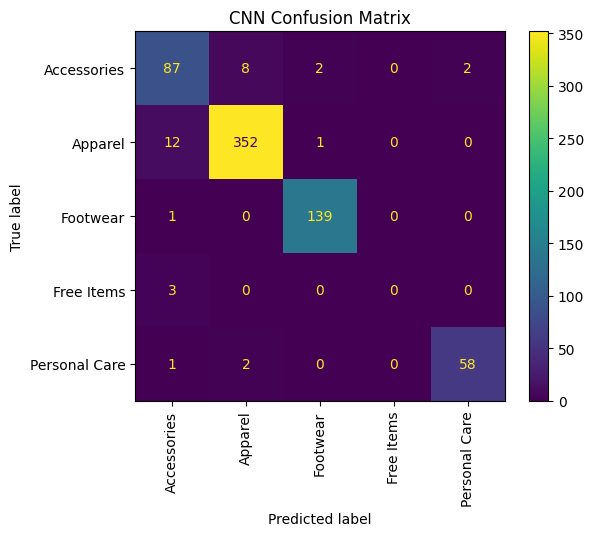

In [78]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
confusionMatrix = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix, display_labels=label_encoder.classes_)
plt.figure(figsize=(20, 20))
cmd.plot()
plt.title("CNN Confusion Matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

## **Pillow package prediction is perfect with few or no false positives. The CNN model classification also has very decent prediction . See the confusion matrix for each one**

# **Update DataFrame with Predicted Label for *master category* for comparision**

In [79]:
# Create a new column in your DataFrame for model predictions
df['model_predicted_masterCategory'] = None  # Initialize with None

# Function to predict masterCategory for images in a directory
def predict_masterCategory(image_dir, model, df):
    for filename in os.listdir(image_dir):
        if filename.endswith(('.jpg', '.jpeg', '.png')):  # Check for image files
            image_id = int(filename.split('.')[0])  # Extract image ID from filename
            image_path = os.path.join(image_dir, filename)

            try:
                img = Image.open(image_path).convert('RGB')
                img = img.resize((64, 64))
                img_array = np.array(img).flatten()
                prediction = model.predict([img_array])  # Predict using trained model

                # Update the DataFrame with predictions
                df.loc[df['id'] == image_id, 'model_predicted_masterCategory'] = prediction[0]

            except Exception as e:
                print(f"Error processing image {filename}: {e}")

# Call the function to predict and update the DataFrame
predict_masterCategory("images", clf, df)


In [80]:
# Show only df with updated rows only
df = df.dropna(subset=['model_predicted_masterCategory'])
# Print the updated DataFrame to verify
print(df.sample(10))

          id  gender masterCategory subCategory   articleType baseColour  \
154    10065     Men        Apparel     Topwear       Tshirts     Yellow   
21616  10286     Men       Footwear       Shoes  Formal Shoes      Black   
15713  44627     Men        Apparel  Bottomwear        Shorts       Grey   
41193   7113  Unisex    Accessories        Bags     Rucksacks      Green   
2836    9657     Men        Apparel     Topwear        Shirts        Red   
17766  55049   Women  Personal Care        Lips      Lipstick      Brown   
992     6242   Women        Apparel     Topwear       Tshirts     Purple   
17898   5011   Women        Apparel     Topwear          Tops       Pink   
17685   6693     Men        Apparel     Topwear       Tshirts      Brown   
38462   9967     Men        Apparel  Bottomwear   Track Pants      Black   

       season    year   usage  \
154      Fall  2011.0  Casual   
21616    Fall  2012.0  Formal   
15713    Fall  2012.0  Casual   
41193  Winter  2015.0  Travel  

# **Plotting the results to show model accuracy. Actual vs Predicted values of Master Category**

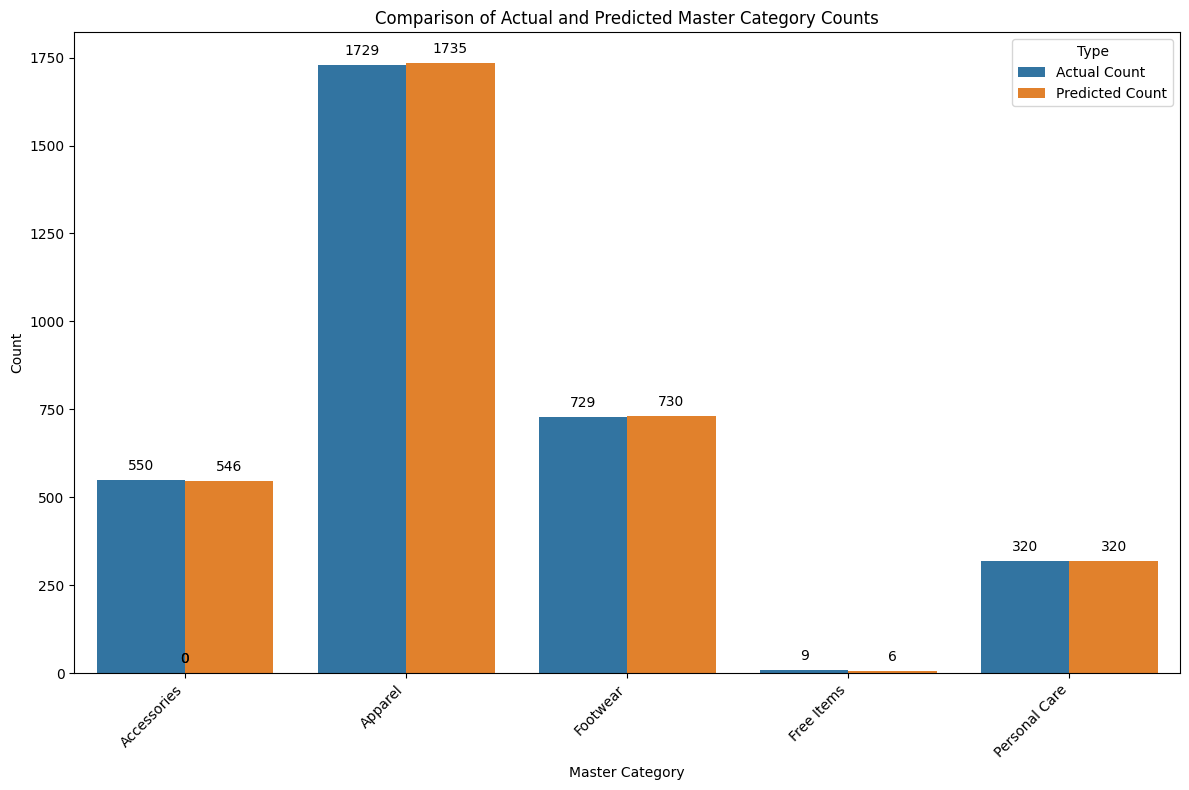

In [81]:
# Count occurrences of masterCategory and model_predicted_masterCategory
master_category_counts = df['masterCategory'].value_counts().reset_index()
predicted_master_category_counts = df['model_predicted_masterCategory'].value_counts().reset_index()

# Rename columns for merging
master_category_counts.columns = ['Category', 'Actual Count']
predicted_master_category_counts.columns = ['Category', 'Predicted Count']

# Merge the dataframes
plot_df = pd.merge(master_category_counts, predicted_master_category_counts, on='Category', how='outer').fillna(0)

# Melt the dataframe for easier plotting with seaborn
plot_df_melted = pd.melt(plot_df, id_vars=['Category'], value_vars=['Actual Count', 'Predicted Count'], var_name='Type', value_name='Count')

# Plotting
plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='Category', y='Count', hue='Type', data=plot_df_melted)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Master Category')
plt.ylabel('Count')
plt.title('Comparison of Actual and Predicted Master Category Counts')
plt.tight_layout()

# Add count annotations
for bar in barplot.patches:
    height = bar.get_height()
    barplot.annotate(f'{int(height)}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 5),  # Slightly above the bar
                     textcoords='offset points',
                     ha='center', va='bottom')  # Center and align text

plt.show()


# **Next Steps and Future Enhancements...**
## **Now that we created many models and identified two best models (Pillow, CNN) to classify images and label them correctly to ~99% accuracy, the Next Steps would be as follows...**

## 1) Enhance the models to classify and predict labels at a detailed level like 'sub-category' or 'product name'.

## 2) Create an endpoint to leverage it for use in real world application

## 3 Additionally, Enhance the models to extract additional features like color, style, shape, text  during image classification
